# Hashovací algoritmy nejen v .NET

Hashovací (_hešovací_) algoritmy jsou důležité nejenom pro počítačovou bezpečnost, ale i mimo ni. Používají se všude tam, kde je nutné jednoduše ověřit shodu dat a nechceme nebo nemůžeme porovnávat data samotná.

Jedná se o matematické algoritmy, které dokáží z libovolných vstupních dat vytvořit hash (otisk, thumbprint, fingerprint, kontrolní součet...), který:

* Má fixní délku, danou konstrukcí hashovacího algoritmu, bez ohledu na délku vstupních dat.
* Je pro stejná data vždy stejný.
* Neumožňuje zpětné odvození původních dat

## Typické hashovací algoritmy

* **[MD5](https://en.wikipedia.org/wiki/MD5)** (128 bitů), **[SHA-1](https://en.wikipedia.org/wiki/SHA-1)** (160 bitů) - zastaralé, dnes se již nehodí pro většinu kryptografických účelů, ale pořád mají své využití.
* **[SHA-2](https://en.wikipedia.org/wiki/SHA-2)** - rodina hashovacích algoritmů, zahrnuje SHA-256, SHA-384, SHA-512. Dnes nejrozšířenější.
* **[SHA-3](https://en.wikipedia.org/wiki/SHA-3)** - nejnovější standard, zahrnuje SHA3-256, SHA3-384, SHA3-512. Není ještě dostupný všude, **v .NETu zatím podporován jenom na některých platformách.**


## Použití v .NETu

Hashovací algoritmy žijí v namespace `System.Security.Cryptography`. Na MD5 si můžeme ukázat typické vlastnosti:

In [5]:
using System.Security.Cryptography;

static string HashMD5(string s) {
    // Hashovací funkce pracují s polem bajtů, proto je potřeba převést string na pole bajtů
    byte[] data = System.Text.Encoding.UTF8.GetBytes(s);
    
    // Vytvoříme instanci MD5 hashovací funkce
    var hash = MD5.Create();

    // Vypočítáme hash
    byte[] hashData = hash.ComputeHash(data);

    // Převedeme bajty na hexadecimální string
    return string.Join(string.Empty, hashData.Select(b => b.ToString("x2")));
}

// Příklad použití
Console.WriteLine("MD5(AHOJ)       = " + HashMD5("AHOJ"));
Console.WriteLine("MD5(AHOK)       = " + HashMD5("AHOK"));
Console.WriteLine("MD5(DLOUHÝTEXT) = " + HashMD5("DLOUHÝTEXT"));

MD5(AHOJ)       = 5d75193725cfb92ce9aee96b5380db06
MD5(AHOK)       = e1f33a0b79e18cbe326c8b1d532377f7
MD5(DLOUHÝTEXT) = 59ce7f82ebede9fbba1f1c002a3a79e3


Všechny hashovací algoritmy jsou poděděné od bázové třídy `HashAlgorithm`, takže můžeme napsat generickou metodu pro hashování:

In [6]:
static string Hash(string s, HashAlgorithm hash) {
    // Hashovací funkce pracují s polem bajtů, proto je potřeba převést string na pole bajtů
    byte[] data = System.Text.Encoding.UTF8.GetBytes(s);
    // Vypočítáme hash
    var hashData = hash.ComputeHash(data);

    // Převedeme bajty na hexadecimální string
    return string.Join(string.Empty, hashData.Select(b => b.ToString("x2")));
}

// Příklad použití

Console.WriteLine("MD5(AHOJ)      = " + Hash("AHOJ", MD5.Create()));
Console.WriteLine("SHA-1(AHOJ)    = " + Hash("AHOJ", SHA1.Create()));
Console.WriteLine("SHA-256(AHOJ)  = " + Hash("AHOJ", SHA256.Create()));
Console.WriteLine("SHA-384(AHOJ)  = " + Hash("AHOJ", SHA384.Create()));
Console.WriteLine("SHA-512(AHOJ)  = " + Hash("AHOJ", SHA512.Create()));
Console.WriteLine("SHA3-256(AHOJ) = " + Hash("AHOJ", SHA3_256.Create()));
Console.WriteLine("SHA3-384(AHOJ) = " + Hash("AHOJ", SHA3_384.Create()));
Console.WriteLine("SHA3-512(AHOJ) = " + Hash("AHOJ", SHA3_512.Create()));

MD5(AHOJ)      = 5d75193725cfb92ce9aee96b5380db06
SHA-1(AHOJ)    = abeb42a478401e2897b9deb1acfcfda5614522ae
SHA-256(AHOJ)  = eadf084bdc2901bd5b9a5399e60767289e4da3c60a60833a87fd3c96dfbf76e1
SHA-384(AHOJ)  = ac6527d57f755be2986bc0f1c40576be56c57d32da0ee341a02791932be6cbf7d83b328ed76bbbfea6fae710c800be89
SHA-512(AHOJ)  = 8849b59816ba95d4c281a00665b9ff58b3574ec271bdcca71360446215a2df281359d0bfcc1670fce68f6aaafb4ddac21c5ccb80104f484e82ee599a1b011c4e
SHA3-256(AHOJ) = 84481687490b64f3706fefc457d343631bc46560564a3b29111180dcb54654a8
SHA3-384(AHOJ) = e034141ccf0a540b3e405dac7e8847ded9c45ad2f08f68e5e5c1ce873b872e6aa5679e5eb0de9077cbe4d7da28673adc
SHA3-512(AHOJ) = e177e4ef2518e5548e74d353153bfcc40a692fdb82feb4c1a8f8812d018d93d41a97ea817853c7d5ff719c6ef7ce8ac98c502735d3bcc872f827bc88ab461916


Tento kód předpokládá, že data jsou dostatečně malá na to, abychom je udrželi v paměti najednou. Pokud tomu tak není, lze použít jako vstup `Stream`. Je nutné počítat s tím, že u objemnějších dat bude výpočet hashe nějakou dobu trvat.

In [7]:
using System.IO;
using System.Diagnostics;

static (string, TimeSpan) HashStream(Stream s, HashAlgorithm hash) {
    // Vypočítáme hash a změříme čas
    Stopwatch sw = Stopwatch.StartNew();
    byte[] hashData = hash.ComputeHash(s);
    sw.Stop();

    // Převedeme bajty na hexadecimální string
    var hashString = string.Join(string.Empty, hashData.Select(b => b.ToString("x2")));
    return (hashString, sw.Elapsed);
}

static void HashFile(string label, string fileName, HashAlgorithm hash) {
    using var fs = File.OpenRead(fileName);
    var (hashString, time) = HashStream(fs, hash);
    Console.WriteLine($"{label,-8} | {time.TotalMilliseconds,4:F0} ms | {hashString}");
}

const string FileName = @"D:\Install\SQL_Server_2022_Express_Advanced.iso";

Console.WriteLine($"{"Hash",-8} | {"Čas",-7} | Hash");
Console.WriteLine(new string('-', 150));
HashFile("MD5", FileName, MD5.Create());
HashFile("SHA-1", FileName, SHA1.Create());
HashFile("SHA-256", FileName, SHA256.Create());
HashFile("SHA-384", FileName, SHA384.Create());
HashFile("SHA-512", FileName, SHA512.Create());
HashFile("SHA3-256", FileName, SHA3_256.Create());
HashFile("SHA3-384", FileName, SHA3_384.Create());
HashFile("SHA3-512", FileName, SHA3_512.Create());
Console.WriteLine(new string('-', 150));
Console.WriteLine($"Velikost souboru {FileName} je {new FileInfo(FileName).Length / 1024 / 1024} MB");

Hash     | Čas     | Hash
------------------------------------------------------------------------------------------------------------------------------------------------------
MD5      | 1445 ms | bcf84c500cd661e95bea8eebd7fbcd1b
SHA-1    | 1277 ms | 0570a2a468771efa8492cf3d74e8eefa5fc929c9
SHA-256  |  690 ms | e8c7cf1f4ad1a52895c99338d100d5a9c0ad6d51a6f76230e095d6f657683d65
SHA-384  | 1496 ms | c508cb2a75978c19dc826d5ad2c7e959078d603e2f511f8f9fdec8552b260f03c1492ec3baff663f011d92b7c632fb1a
SHA-512  | 1487 ms | 292431b2f3e8d97da2dfccac2e069609dbbc3e4fee43d928cb1ac903fab3b31c09567f6d0294aa677385637b71e5b40a6cfe42261a176d5a63fbd4900597d3d8
SHA3-256 | 2243 ms | d1bd951e53021f9dee5218566748faa940a96cf31a75ef139542bfb328baa601
SHA3-384 | 2772 ms | c0586208ca40ab228a066437033dd045be49ad794b27b70c482135aeb376410c4b40ceeb0321ba59bd0aaffd758fb431
SHA3-512 | 3963 ms | 8a5d02d8e61a7083491d8d3be2093eb2e8be8999fbbe7f271359f17a67f49b9cf7d6ba302ec542bfbf7f4770fa207f19ccf854c9b8fc7366f381455af7d2f0c3

## Kolizní zprávy

Vzhledem k tomu, že množina možných vstupních dat (neomezená délka) je větší než množina možných výstupních dat (fixní délka), logicky musejí existovat tzv. kolizní zprávy (collision messages). Tj. dvoje různá vstupní data, která mají stejný hash. U algoritmů SHA-2 a SHA-3 je (zatím) neumíme najít. U MD5 a SHA-1 už ano.

Příklad kolizní zprávy ([zdroj](https://en.wikipedia.org/wiki/MD5#Collision_vulnerabilities)):

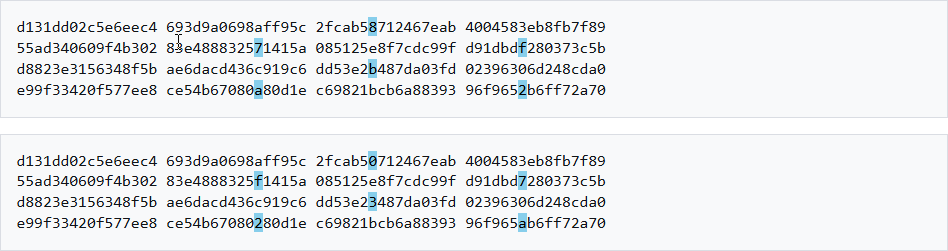

In [8]:
// Stringová reprezentace kolizních zpráv
var msg1string = "d131dd02c5e6eec4693d9a0698aff95c2fcab58712467eab4004583eb8fb7f8955ad340609f4b30283e488832571415a085125e8f7cdc99fd91dbdf280373c5bd8823e3156348f5bae6dacd436c919c6dd53e2b487da03fd02396306d248cda0e99f33420f577ee8ce54b67080a80d1ec69821bcb6a8839396f9652b6ff72a70";
var msg2string = "d131dd02c5e6eec4693d9a0698aff95c2fcab50712467eab4004583eb8fb7f8955ad340609f4b30283e4888325f1415a085125e8f7cdc99fd91dbd7280373c5bd8823e3156348f5bae6dacd436c919c6dd53e23487da03fd02396306d248cda0e99f33420f577ee8ce54b67080280d1ec69821bcb6a8839396f965ab6ff72a70";

// Převedeme hexadecimální stringy na pole bajtů
var msg1 = Enumerable.Range(0, msg1string.Length / 2).Select(i => Convert.ToByte(msg1string.Substring(i * 2, 2), 16)).ToArray();
var msg2 = Enumerable.Range(0, msg2string.Length / 2).Select(i => Convert.ToByte(msg2string.Substring(i * 2, 2), 16)).ToArray();

// Funkce pro výpočet MD5 hashe
static string HashBytesMD5(byte[] data) {
    // Vytvoříme instanci MD5 hashovací funkce
    var hash = MD5.Create();

    // Vypočítáme hash
    byte[] hashData = hash.ComputeHash(data);

    // Převedeme bajty na hexadecimální string
    return string.Join(string.Empty, hashData.Select(b => b.ToString("x2")));
}

// Vypočítáme MD5 hash pro obě zprávy
Console.WriteLine($"MD5(msg1):    {HashBytesMD5(msg1)}");
Console.WriteLine($"MD5(msg2):    {HashBytesMD5(msg2)}");
Console.WriteLine($"msg1 == msg2: {msg1.SequenceEqual(msg2)}");


MD5(msg1):    79054025255fb1a26e4bc422aef54eb4
MD5(msg2):    79054025255fb1a26e4bc422aef54eb4
msg1 == msg2: False


Přesto algoritmy MD5 a SHA-1 nejsou bezcenné a lze je nadále používat, např.:

* Pro porovnání změněných souborů, kde nepředpokládáme cílený útok. Například Azure Storage a AzCopy využívá MD5, protože má malou délku.
* Při [generování jednorázových hesel](https://www.youtube.com/watch?v=u352xYwSGAs), kde jsou na ně kladeny nižší nároky.